# Spectrum Analysis of ASASSN-14cn

In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib import gridspec

# for filtering time-tag events by time
from costools import splittag
# for processing COS data
import calcos

# for system files
import glob
import os
from pathlib import Path

# for downloading the data
from astroquery.mast import Observations

# For supressing an unhelpful warning:
import warnings
from astropy.units import UnitsWarning

The following tasks in the costools package can be run with TEAL:
         splittag                 timefilter                 x1dcorr


# Download corresponding corrtag files

In [2]:
# Make directories
data_dir = Path('./data/')
output_dir = Path('./output/')  # Using the pathlib style of system path
plots_dir = output_dir / 'plots'

# Make the directories in case they don't exist
data_dir.mkdir(exist_ok=True); 
output_dir.mkdir(exist_ok=True); 
plots_dir.mkdir(exist_ok=True)

Jump to Lightcurve Examination if observation and reference data already downloaded. \
Skip this and the next section.

In [3]:
# Find all MAST data on this obs id:
obs_id = 'leqk40010'

# Guery the MAST archive for data with observation id starting with lcxv1304
q1 = Observations.query_criteria(obs_id=obs_id)

# Make a list of all products we could download associates with this file
pl = Observations.get_product_list(q1)

# Filter to a list of only the products which are association files
asn_list = pl[pl["productSubGroupDescription"] == 'ASN']

# Filter to a list of only the products which are rawtag files
rawtag_list = pl[(pl["productSubGroupDescription"] == 'RAWTAG_A') | 
                 (pl["productSubGroupDescription"] == 'RAWTAG_B')]

# Filter to a list of only the products which are corrtag files
corrtag_list = pl[(pl["productSubGroupDescription"] == 'CORRTAG_A') | 
                  (pl["productSubGroupDescription"] == 'CORRTAG_B')]

# Filter to a list of only the products which are x1d files
x1d_list = pl[pl["productSubGroupDescription"] == 'X1D']


# Download the four file lists to the data directory
rawtag_locs  = Observations.download_products(rawtag_list,   download_dir=str(data_dir))
asn_locs     = Observations.download_products(asn_list,      download_dir=str(data_dir))
corrtag_locs = Observations.download_products(corrtag_list,  download_dir=str(data_dir))
x1d_locs     = Observations.download_products(x1d_list,      download_dir=str(data_dir))

# =========================================

# move the files to the base data directory
for lpath in rawtag_locs['Local Path']:
    Path(lpath).replace(data_dir/os.path.basename(lpath))
for lpath in asn_locs['Local Path']:
    Path(lpath).replace(data_dir/os.path.basename(lpath))
    asn_name = os.path.basename(lpath)
for lpath in corrtag_locs['Local Path']:
    Path(lpath).replace(data_dir/os.path.basename(lpath))
    corrtag_name = os.path.basename(lpath)
for lpath in x1d_locs['Local Path']:
    Path(lpath).replace(data_dir/os.path.basename(lpath))
    x1d_name = os.path.basename(lpath)
    
# Delete the now-empty nested subdirectories
import os, shutil
shutil.rmtree(data_dir/'mastDownload')

# Preparing Reference File (check the latest version)

In [4]:
# Check the version of CRD file
crd_ctx = fits.getheader(data_dir/corrtag_name)['CRDS_CTX']
print(f'Corresponding CRDS with {obs_id} was: {crd_ctx}')

Corresponding CRDS with leqk40010 was: hst_1041.pmap


In [5]:
%%capture cap --no-stderr
'''
The above ^ allows us to redirect the cell's output into a txt file 
created in the next cell.
This avoids a very long printed output.
'''
%env CRDS_SERVER_URL https://hst-crds.stsci.edu
# The above^ sets an environment for crds to look for the reference online
%env CRDS_PATH ./data/reference/ 
# The above^ tells crds where to save the files it downloads

'''
The next command depends on your context and pmap file - it looks up the 
specified pmap "context" file, which tells it what reference files to download. 
It then downloads these to the CRDS_PATH directory.
You may wish to update this pmap if there is a newer pmap file - check 
https://hst-crds.stsci.edu
The files are around 1G.
'''
!crds bestrefs --files data/*raw*.fits  --sync-references=2 --update-bestrefs --new-context 'hst_1041.pmap' 

In [6]:
outputdir = Path('./output/')
# This file will contain the output of the last cell
with open(str(outputdir/'crds_output_1.txt'), 'w') as f:
    f.write(cap.stdout)

In [7]:
crds_output_dict = {}  # pair each line with its line number, start at 0
with open(str(outputdir/'crds_output_1.txt'), 'r') as cell_outputs:  # open the file
    for linenum, line in enumerate(cell_outputs):  # loop through lines
        crds_output_dict[linenum] = line[:-1]  # save each line to dict
# Get the length of the dictionary - how many lines of output
total_lines = len(crds_output_dict)

print(
    f"Printing the first and last 5 lines of {total_lines} lines output by the previous cell:\n")
for i in np.append(range(5), np.subtract(total_lines - 1, range(5)[::-1])):
    print(f"Line {i}:   \t", crds_output_dict[i])

# Delete the contents of the dict to avoid 'garbage' filling memory
crds_output_dict.clear()

Printing the first and last 5 lines of 172 lines output by the previous cell:

Line 0:   	 env: CRDS_SERVER_URL=https://hst-crds.stsci.edu
Line 1:   	 env: CRDS_PATH=./data/reference/
Line 2:   	 CRDS - INFO -  Fetching  ./data/reference/mappings/hst/hst_wfpc2_wf4tfile_0250.rmap      678 bytes  (1 / 140 files) (0 / 1.7 M bytes)
Line 3:   	 CRDS - INFO -  Fetching  ./data/reference/mappings/hst/hst_wfpc2_shadfile_0250.rmap      977 bytes  (2 / 140 files) (678 / 1.7 M bytes)
Line 4:   	 CRDS - INFO -  Fetching  ./data/reference/mappings/hst/hst_wfpc2_offtab_0250.rmap      642 bytes  (3 / 140 files) (1.7 K / 1.7 M bytes)
Line 167:   	 CRDS - INFO -  Fetching  ./data/reference/references/hst/cos/x1u1459il_brf.fits    14.4 K bytes  (19 / 20 files) (796.2 M / 930.4 M bytes)
Line 168:   	 CRDS - INFO -  Fetching  ./data/reference/references/hst/cos/z6n16117l_flat.fits  134.2 M bytes  (20 / 20 files) (796.2 M / 930.4 M bytes)
Line 169:   	 CRDS - INFO -  0 errors
Line 170:   	 CRDS - INFO -  0

In [9]:
# This cell is for ensuring you have a valid "lref" directory of reference files.
if not os.environ.get('lref'):
    if os.path.exists('/grp/hst/cdbs/lref/'):  # If on STScI Network/VPN
        os.environ['lref'] = '/grp/hst/cdbs/lref/'
        print("It looks like you are probably on the STScI network; setting lref to '/grp/hst/cdbs/lref/'")
    else:  # If not on STScI Network/VPN
        # PLEASE EDIT THIS PATH
        os.environ['lref'] = './data/reference/references/hst/cos'
        if not os.path.exists(os.environ['lref']):  # Check if that path exists
            print("It doesn't look like that's a valid path. Deleting it.")
            del os.environ['lref']  # delete this nonexistant path
else:
    found_lref = Path(os.environ.get('lref'))
    print(f"You already have an lref path in your environment variables -\
 It's {found_lref}\n")

assert os.path.exists(os.environ['lref']), f"The path to your lref directory is invalid ({os.environ['lref']})" 

You already have an lref path in your environment variables - It's data/reference/references/hst/cos



# Lightcurve Examination

In [13]:
# Find all of the corrtag files:
corrtag_files = sorted(glob.glob(str(data_dir/'*corrtag*.fits')))
os.environ['lref'] = './data/reference/references/hst/cos'

Event duration: 1695.2
Event duration: 2502.208
Event duration: 2502.208
Event duration: 2502.176
Event duration: 2502.208
Event duration: 2502.208


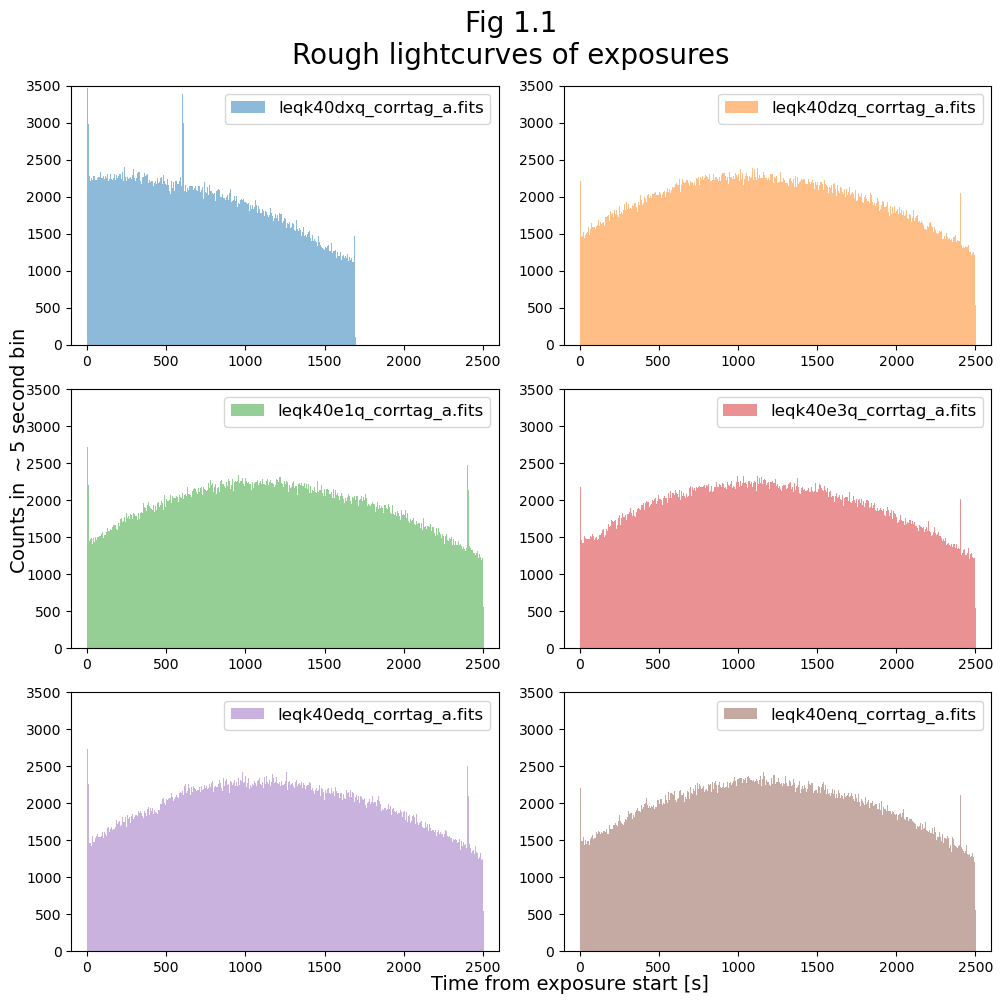

In [16]:
# Build the figure structure
fig = plt.figure(figsize=(10, 10))
# Using gridspec to let us control panel sizes and locations
gs = fig.add_gridspec(nrows=3, ncols=2)
# Get the time data for each exposure
binsize = 5  # Number of seconds in a bin
for i, ctag in enumerate(corrtag_files):
    ax = fig.add_subplot(gs[int(i/2), i % 2])  # make the subplot
    ax.set_xlim([-100, 2600])
    ax.set_ylim([0, 3500])
    ctab = Table.read(ctag, 1)  # read the data into a table
    event_times = ctab['TIME']
    print('Event duration:', max(event_times))
    # plot the histogram of times
    hist = ax.hist(
        event_times,
        bins=np.arange(0, max(event_times)+binsize, binsize),
        alpha=0.5, 
        label=os.path.basename(ctag),
        color=['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6'][i])
    plt.legend(fontsize=12)
# Format the figure and add text:
plt.suptitle("Fig 1.1\nRough lightcurves of exposures", fontsize=20)
fig.text(
    x=0.42, y=-0.0001,
    s="Time from exposure start [s]",
    fontsize=14
)
fig.text(
    y=0.42, x=-0.001,
    s=f"Counts in $\sim${binsize} second bin",
    rotation='vertical',
    fontsize=14
)
plt.tight_layout()
plt.savefig(plots_dir / 'compare_exposures.png', bbox_inches='tight', dpi=200)

In [17]:
transit_exp_1 = [exp for exp in corrtag_files if "dxq" in exp][0]
transit_exp_2 = [exp for exp in corrtag_files if "dzq" in exp][0]
transit_exp_3 = [exp for exp in corrtag_files if "e1q" in exp][0]
transit_exp_4 = [exp for exp in corrtag_files if "e3q" in exp][0]
transit_exp_5 = [exp for exp in corrtag_files if "edq" in exp][0]
transit_exp_6 = [exp for exp in corrtag_files if "enq" in exp][0]
transit_exp = [transit_exp_1, transit_exp_2, transit_exp_3, 
               transit_exp_4, transit_exp_5, transit_exp_6]

transit_basename = [[], [], [], [], [], []]
for i in range(len(transit_basename)):
    transit_basename[i] = os.path.basename(transit_exp[i]).split('_')[0]

In [18]:
# Make the folder in which to store the newly split corrtag files:
spec_int_dir = output_dir / 'spec_intervals'
# An output directory for files split on specified intervals
spec_int_dir.mkdir(exist_ok=True)

# Use CAUTION when deleting files - as in the next lines
# These lines delete existing processed files in the output directory
#   if you have run this cell before, this will overwrite previous outputs
delete_old_files = True
if delete_old_files and any(spec_int_dir.glob("*corrtag*fits")):
    print("Deleting files from a previous run...")
    [old_file.unlink() for old_file in list(spec_int_dir.glob("*corrtag*fits"))]

# Import the split list from lightcurves
split_list = [[0., 1427., 1505.,  1695.],
              [0., 0.   , 0.   ,  2502.], # <=== No eclipse
              [0., 0.   , 0.   ,  2502.], # <=== No eclipse
              [0., 104. , 175. ,  2502.],
              [0., 365. , 440. ,  2502.],
              [0., 620. , 700. ,  2502.]]

# Run splittag using our specified times:
for i in range(len(transit_exp)):
    
    splittag.splittag(infiles=transit_exp[i],
                      outroot=f'./output/spec_intervals/{transit_basename[i]}',
                      time_list=split_list[i])

./output/spec_intervals/leqk40dxq_1_corrtag_a.fits written
./output/spec_intervals/leqk40dxq_2_corrtag_a.fits written
./output/spec_intervals/leqk40dxq_3_corrtag_a.fits written
./output/spec_intervals/leqk40dzq_1_corrtag_a.fits written
./output/spec_intervals/leqk40e1q_1_corrtag_a.fits written
./output/spec_intervals/leqk40e3q_1_corrtag_a.fits written
./output/spec_intervals/leqk40e3q_2_corrtag_a.fits written
./output/spec_intervals/leqk40e3q_3_corrtag_a.fits written
./output/spec_intervals/leqk40edq_1_corrtag_a.fits written
./output/spec_intervals/leqk40edq_2_corrtag_a.fits written
./output/spec_intervals/leqk40edq_3_corrtag_a.fits written
./output/spec_intervals/leqk40enq_1_corrtag_a.fits written
./output/spec_intervals/leqk40enq_2_corrtag_a.fits written
./output/spec_intervals/leqk40enq_3_corrtag_a.fits written


# Extract sub-spectrum

In [19]:
# Import all the splitted data needs to be extract
spec_outlist = sorted(glob.glob('./output/spec_intervals/*fits'))

In [20]:
'''
Require space ~5G
'''

for split_corrtag in spec_outlist:  # When we run CalCOS on corrtags, we must go 1-by-1
    # Define epoch as which chunk of the initial exposure. epoch 2 contains the transit.
    epoch_number = os.path.basename(split_corrtag).split('_')[1]
    print(f"Extracting file {split_corrtag} using CalCOS")
    # Make a sub-directory of output/calcos/ named for each epoch:
    cal_output_dir = f'./output/calcos_processed_split/epoch{epoch_number}/'
    os.makedirs(cal_output_dir, exist_ok=True)
    # Extract the spectrum from each of the sub-exposures:
    calcos.calcos(split_corrtag, outdir=cal_output_dir, verbosity=0)
# Print a message at the end to let us know it's finished:
print("Done running the pipeline.")

Extracting file ./output/spec_intervals/leqk40dxq_1_corrtag_a.fits using CalCOS
CALCOS version 3.4.3
numpy version 1.23.3
astropy version 5.1
Begin 19-Oct-2022 01:30:37 CDT
Don't add simulated wavecal because association has no exp_swave members
Shifting to -513, -4
Shifting to -512, -4
Shifting to -511, -4
Shifting to -512, -4
Shifting to -511, -4
Shifting to -513, -3
Shifting to -512, -3
Shifting to -511, -3
Shifting to -512, -3
Shifting to -511, -3
Shifting to -513, -2
Shifting to -512, -2
Shifting to -511, -2
Shifting to -512, -2
Shifting to -511, -2
Shifting to -513, -1
Shifting to -512, -1
Shifting to -511, -1
Shifting to -512, -1
Shifting to -511, -1
Shifting to -513, 0
Shifting to -512, 0
Shifting to -511, 0
Shifting to -512, 0
Shifting to -511, 0
Shifting to -513, 1
Shifting to -512, 1
Shifting to -511, 1
Shifting to -512, 1
Shifting to -511, 1
Shifting to -513, 2
Shifting to -512, 2
Shifting to -511, 2
Shifting to -512, 2
Shifting to -511, 2
Extraction algorithm = TWOZONE
Two

Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Extracting file ./output/spec_intervals/leqk40edq_1_corrtag_a.fits using CalCOS
CALCOS version 3.4.3
numpy version 1.23.3
astropy version 5.1
Don't add simulated wavecal because association has no exp_swave members
Shifting to -16, -4
Shifting to -15, -4
Shifting to -15, -4
Shifting to -16, -3
Shifting to -15, -3
Shifting to -15, -3
Shifting to -16, -2
Shifting to -15, -2
Shifting to -15, -2
Shifting to -16, -1
Shifting to -15, -1
Shifting to -15, -1
Shifting to -16, 0
Shifting to -15, 0
Shifting to -15, 0
Shifting to -16, 1
Shifting to -15, 1
Shifting to -15, 1
Shifting to -16, 2
Shifting to -15, 2
Shifting to -15, 2
Extraction algorithm = TWOZONE
Two-zone extraction method
Using profile centroid of 463.884577
Calculating background for reference profile
Using extraction percentiles of:
0.500000 and 99.500000 (outer region)
and 10.000000 and 90.000000 (inner region)
Extrac

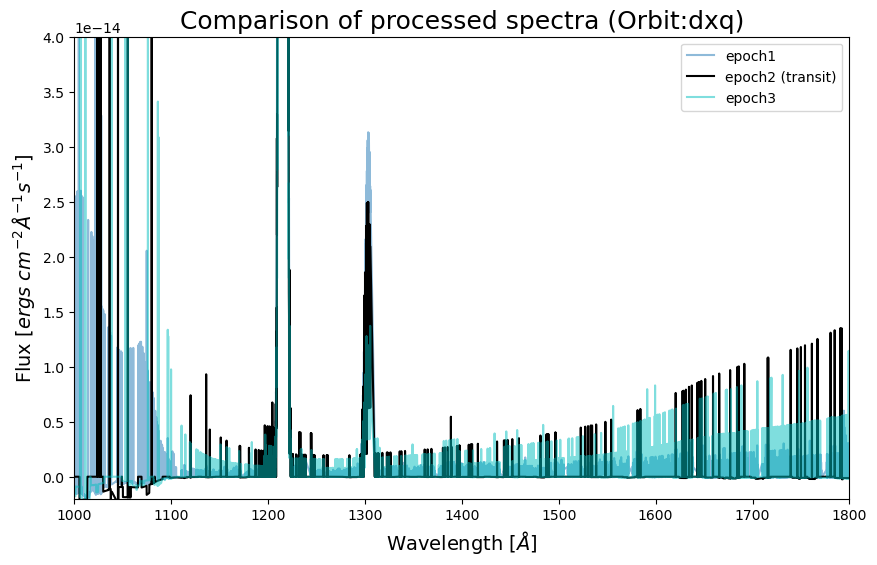

In [21]:
# Find all the `x1d` files:
'''
Orbit labels:
dxq, dzq, e1q, e3q, edq, enq
'''
orbit_id = 'dxq'
processed_files = sorted(glob.glob('output/calcos_processed_split/epoch*/leqk40'+
                                   orbit_id+'_?_x1d.fits'))

# Set up figure
plt.figure(figsize=(10, 6))

for i, pfile in enumerate(processed_files):  # Loop through
    epoch_label = pfile.split('/')[2]
    if "2" in epoch_label: # Mark the transit
        epoch_label += " (transit)"
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UnitsWarning, append=True)
        w, f, ferr, dq = Table.read(pfile)[0]['WAVELENGTH', 'FLUX', 'ERROR', 'DQ']
    dq_mask = np.where(dq == 0) # filter to good quality data
    w, f, ferr = w[dq_mask], f[dq_mask], ferr[dq_mask]
    plt.plot(w, f,  # Plot each epoch
             # Epoch2 should stand out
             alpha=[0.5, 1, 0.5][i], c=['C0', 'k', 'c'][i],
             label=epoch_label)  # Label with the epoch name
# Format plot
#plt.ylim(-3E-15, 5E-14)
plt.title(f"Comparison of processed spectra (Orbit:{orbit_id})", size=18)
plt.xlabel("Wavelength [$\AA$]", size=14)
plt.ylabel("Flux [$ergs\ cm^{-2} \AA^{-1}s^{-1}$]", size=14)
plt.xlim(1000, 1800)
plt.ylim(-2e-15, 0.4e-13)
plt.legend()
plt.savefig(plots_dir / f"Compare_spectrum.png", dpi=200)

# Extract Original Spectrum

In [22]:
# Find all rawtag files
rawtag_files = glob.glob(str(data_dir/'*rawtag_a*.fits'))

In [23]:
%%capture cap --no-stderr 
# Above ^ again, capture the output and save it in the next cell
# Require space ~ 2G

'''
1. Param specifies which asn file to run the pipeline on
2. verbosity param: [0 = don't print much at all to the console or text 
   file, 1 = print some, 2 = print everything]
3. save all resulting files in this subdirectory in our output directory
'''
calcos.calcos(str(data_dir/asn_name),
              verbosity=2, 
              outdir=str(outputdir/"calcos_processed_original"))

/Users/willyu/opt/anaconda3/envs/calcos_env/lib/python3.10/site-packages/calcos/fpavg.py:1203: RuntimeWarning: invalid value encountered in divide
  conversion = data.field("flux") / data.field("net")


In [24]:
# This file now contains the output of the last cell
with open(str(outputdir/'output_calcos_1.txt'), 'w') as f:
    f.write(cap.stdout)

In [25]:
calcos_output_dict = {}  # pair each line with its line number, start at 0
with open(str(outputdir/'output_calcos_1.txt'), 'r') as cell_outputs:  # open the file
    for linenum, line in enumerate(cell_outputs):  # loop through lines
        calcos_output_dict[linenum] = line[:-1]  # save each line to dict
# Get the length of the dictionary - how many lines of output
total_lines = len(calcos_output_dict)

print(
    f"Printing the first and last 5 lines of {total_lines} lines output by the previous cell:\n")
for i in np.append(range(5), np.subtract(total_lines - 1, range(5)[::-1])):
    print(f"Line {i}:   \t", calcos_output_dict[i])

calcos_output_dict.clear()  # Delete the contents of the dict

Printing the first and last 5 lines of 2594 lines output by the previous cell:

Line 0:   	 Warning:  Creating output directory 'output/calcos_processed_original'.
Line 1:   	 CALCOS version 3.4.3
Line 2:   	 numpy version 1.23.3
Line 3:   	 astropy version 5.1
Line 4:   	 Association file = data/leqk40010_asn.fits
Line 2589:   	 updateMempresent
Line 2590:   	 copySptFile
Line 2591:   	 Warning:  spt file not found, so not copied to product
Line 2592:   	 End   19-Oct-2022 01:47:35 CDT
Line 2593:   	 elapsed time = 171.0 sec. = 2.85 min.


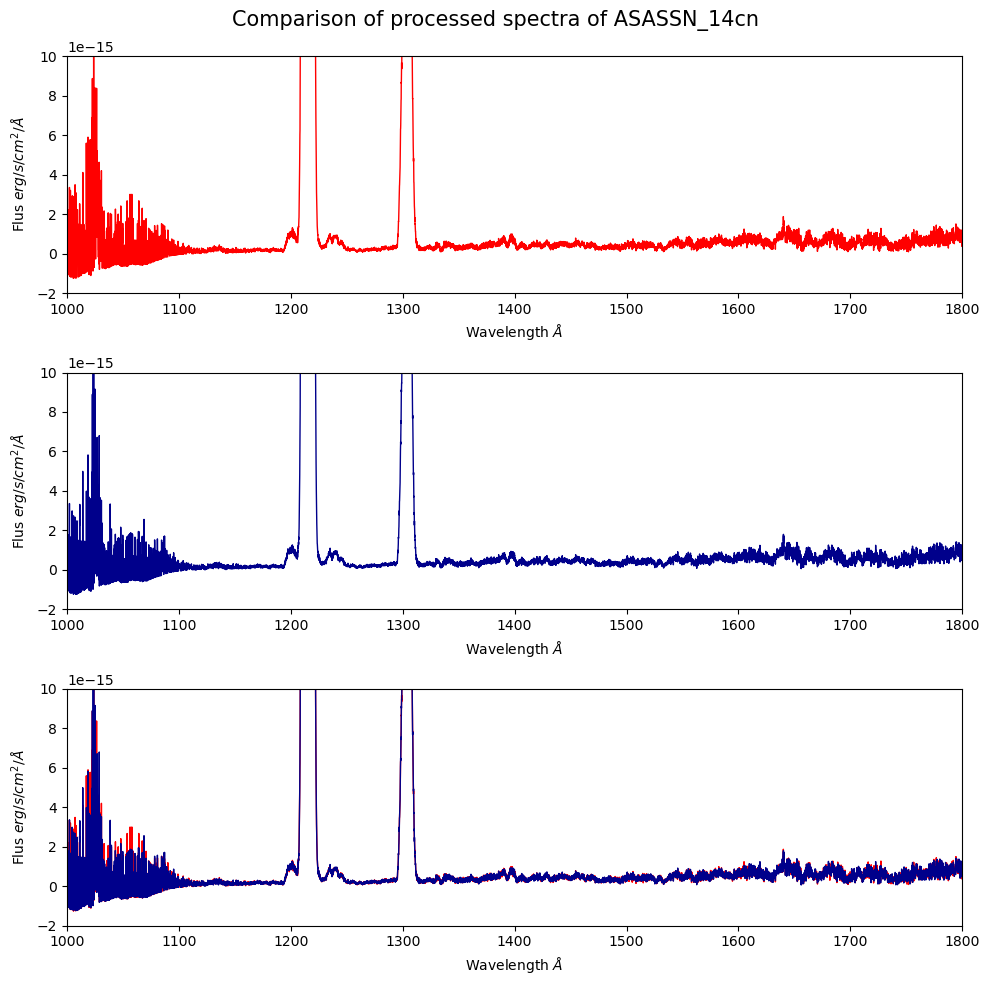

In [27]:
# ===================
# Spectrum Comparison
# ===================
# Compare STScI calibrated spectrum and our spectrum
object_name = 'ASASSN_14cn'


# Import spectrum calibrated by STScI
data_path = '../HST_DATA/'+object_name+'/'
x1dsum_stsci = Table.read(data_path+'leqk40010_x1dsum.fits')
wvln_sts = x1dsum_stsci['WAVELENGTH'].T
flux_sts = x1dsum_stsci['FLUX'].T
eror_sts = x1dsum_stsci['ERROR'].T
dtqt_sts = x1dsum_stsci['DQ_WGT'].T
# Convert the data quality (DQ) weight into a boolean we can use 
# to mask the data
dqwgt_sts = np.asarray(dtqt_sts, dtype=bool)

# Import spectrum extracted by us using CalCOS
x1dsum_calcos = Table.read(str(outputdir/'calcos_processed_original/leqk40010_x1dsum.fits'))
wvln_cal = x1dsum_calcos['WAVELENGTH'].T
flux_cal = x1dsum_calcos['FLUX'].T
eror_cal = x1dsum_calcos['ERROR'].T
dtqt_cal = x1dsum_calcos['DQ_WGT'].T
# Convert the data quality (DQ) weight into a boolean we can use 
# to mask the data
dqwgt_cal = np.asarray(dtqt_cal, dtype=bool)

# Plot the spectrums
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(wvln_sts[dqwgt_sts], flux_sts[dqwgt_sts], lw=1, c='red',)
axs[1].plot(wvln_cal[dqwgt_cal], flux_cal[dqwgt_cal], lw=1, c='darkblue')
axs[2].plot(wvln_sts[dqwgt_sts], flux_sts[dqwgt_sts], lw=1, c='red',)
axs[2].plot(wvln_cal[dqwgt_cal], flux_cal[dqwgt_cal], lw=1, c='darkblue')

fig.suptitle('Comparison of processed spectra of '+object_name, size=15)
plt.setp(axs, xlim=(1000,1800), 
              ylim=(-2e-15, 1e-14))
plt.setp(axs, xlabel=('Wavelength $\AA$'),
              ylabel=('Flus $erg /s /cm^{2} /\AA$'))

plt.tight_layout()